In [2]:
from IPython.display import Image
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import pickle
import requests
from bs4 import BeautifulSoup
import numpy as np
import sys

# Goal: scrape university ranking info 

## explore the website and identify needed elements

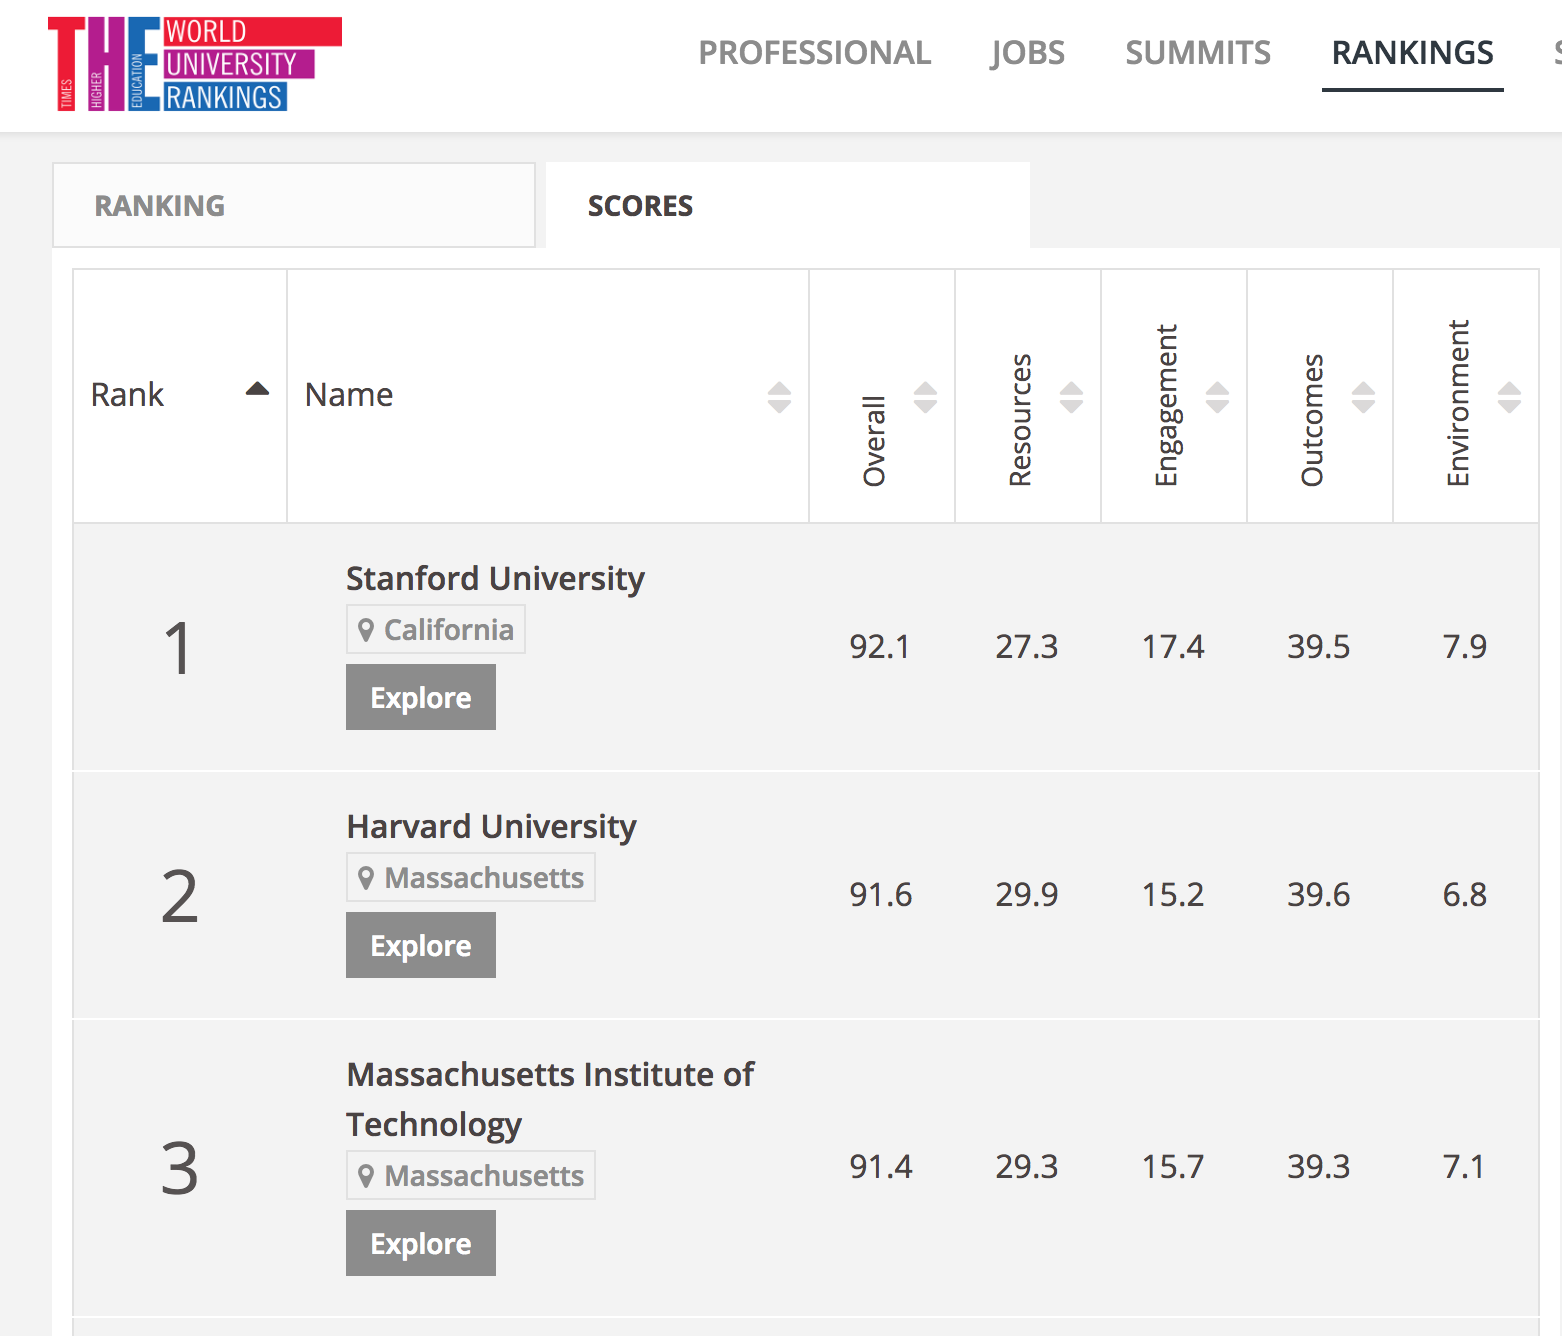

In [14]:
Image("ranking list.png")

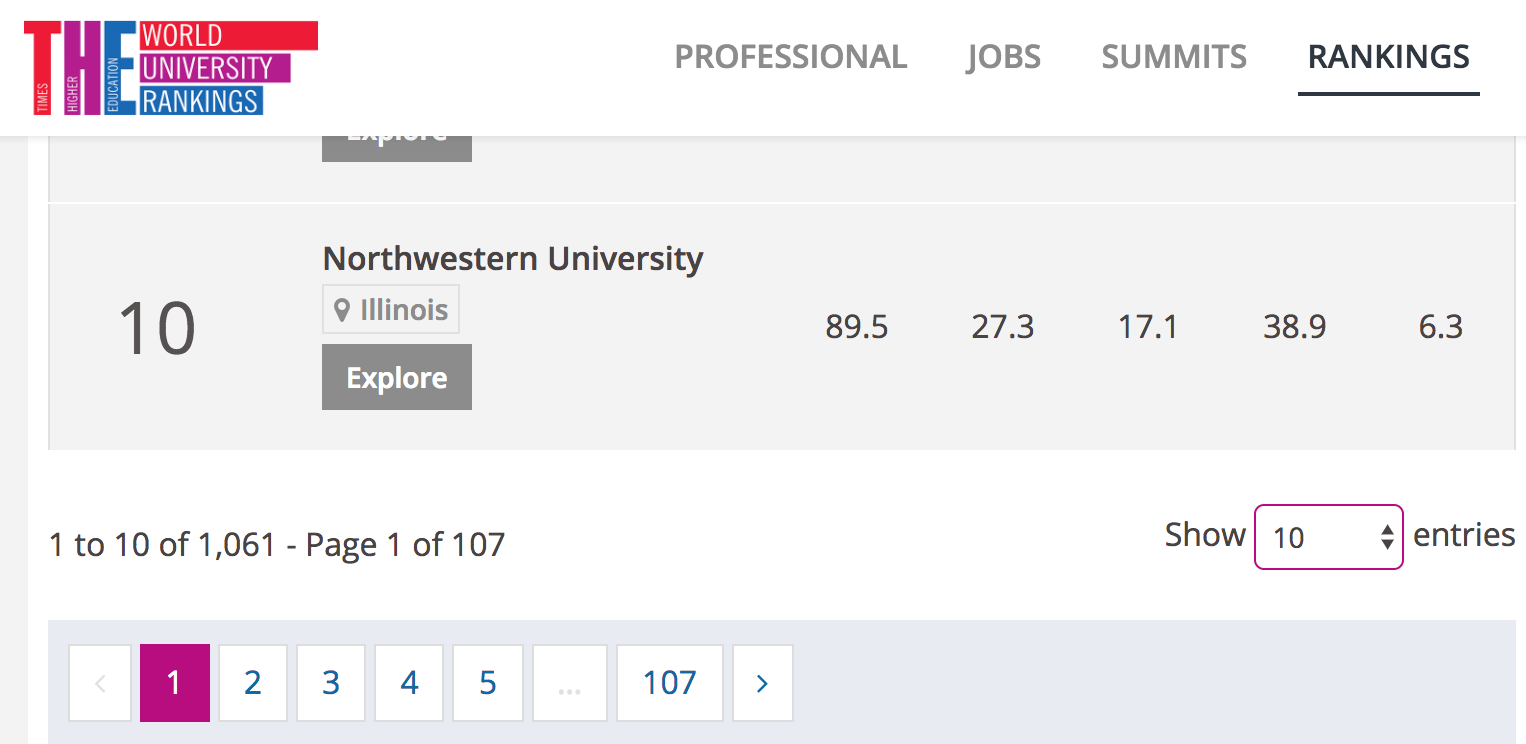

In [17]:
Image("ranking page.png")

In [18]:
page_number =[0,1,2,3,4] # tab numbers, only this vairable needs to be modified if more data are needed

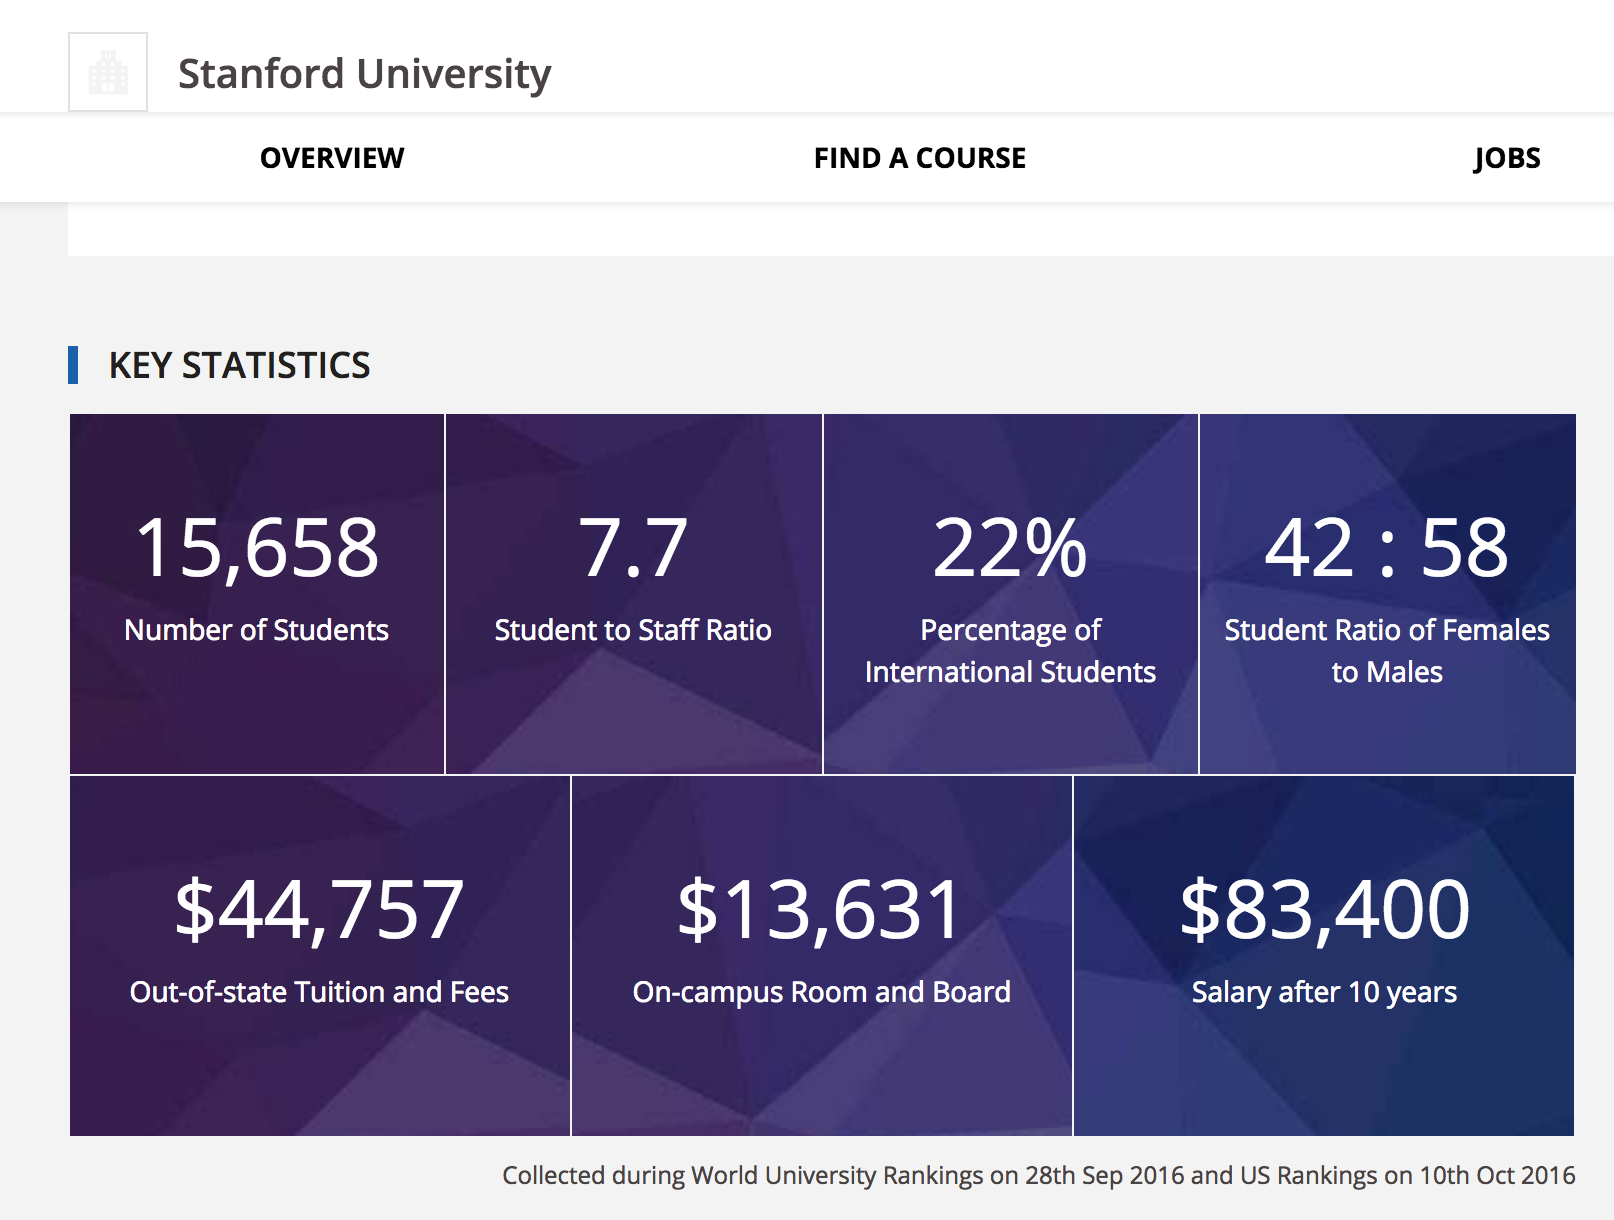

In [15]:
Image("university statistics.png")

## come up with a scraping plan 

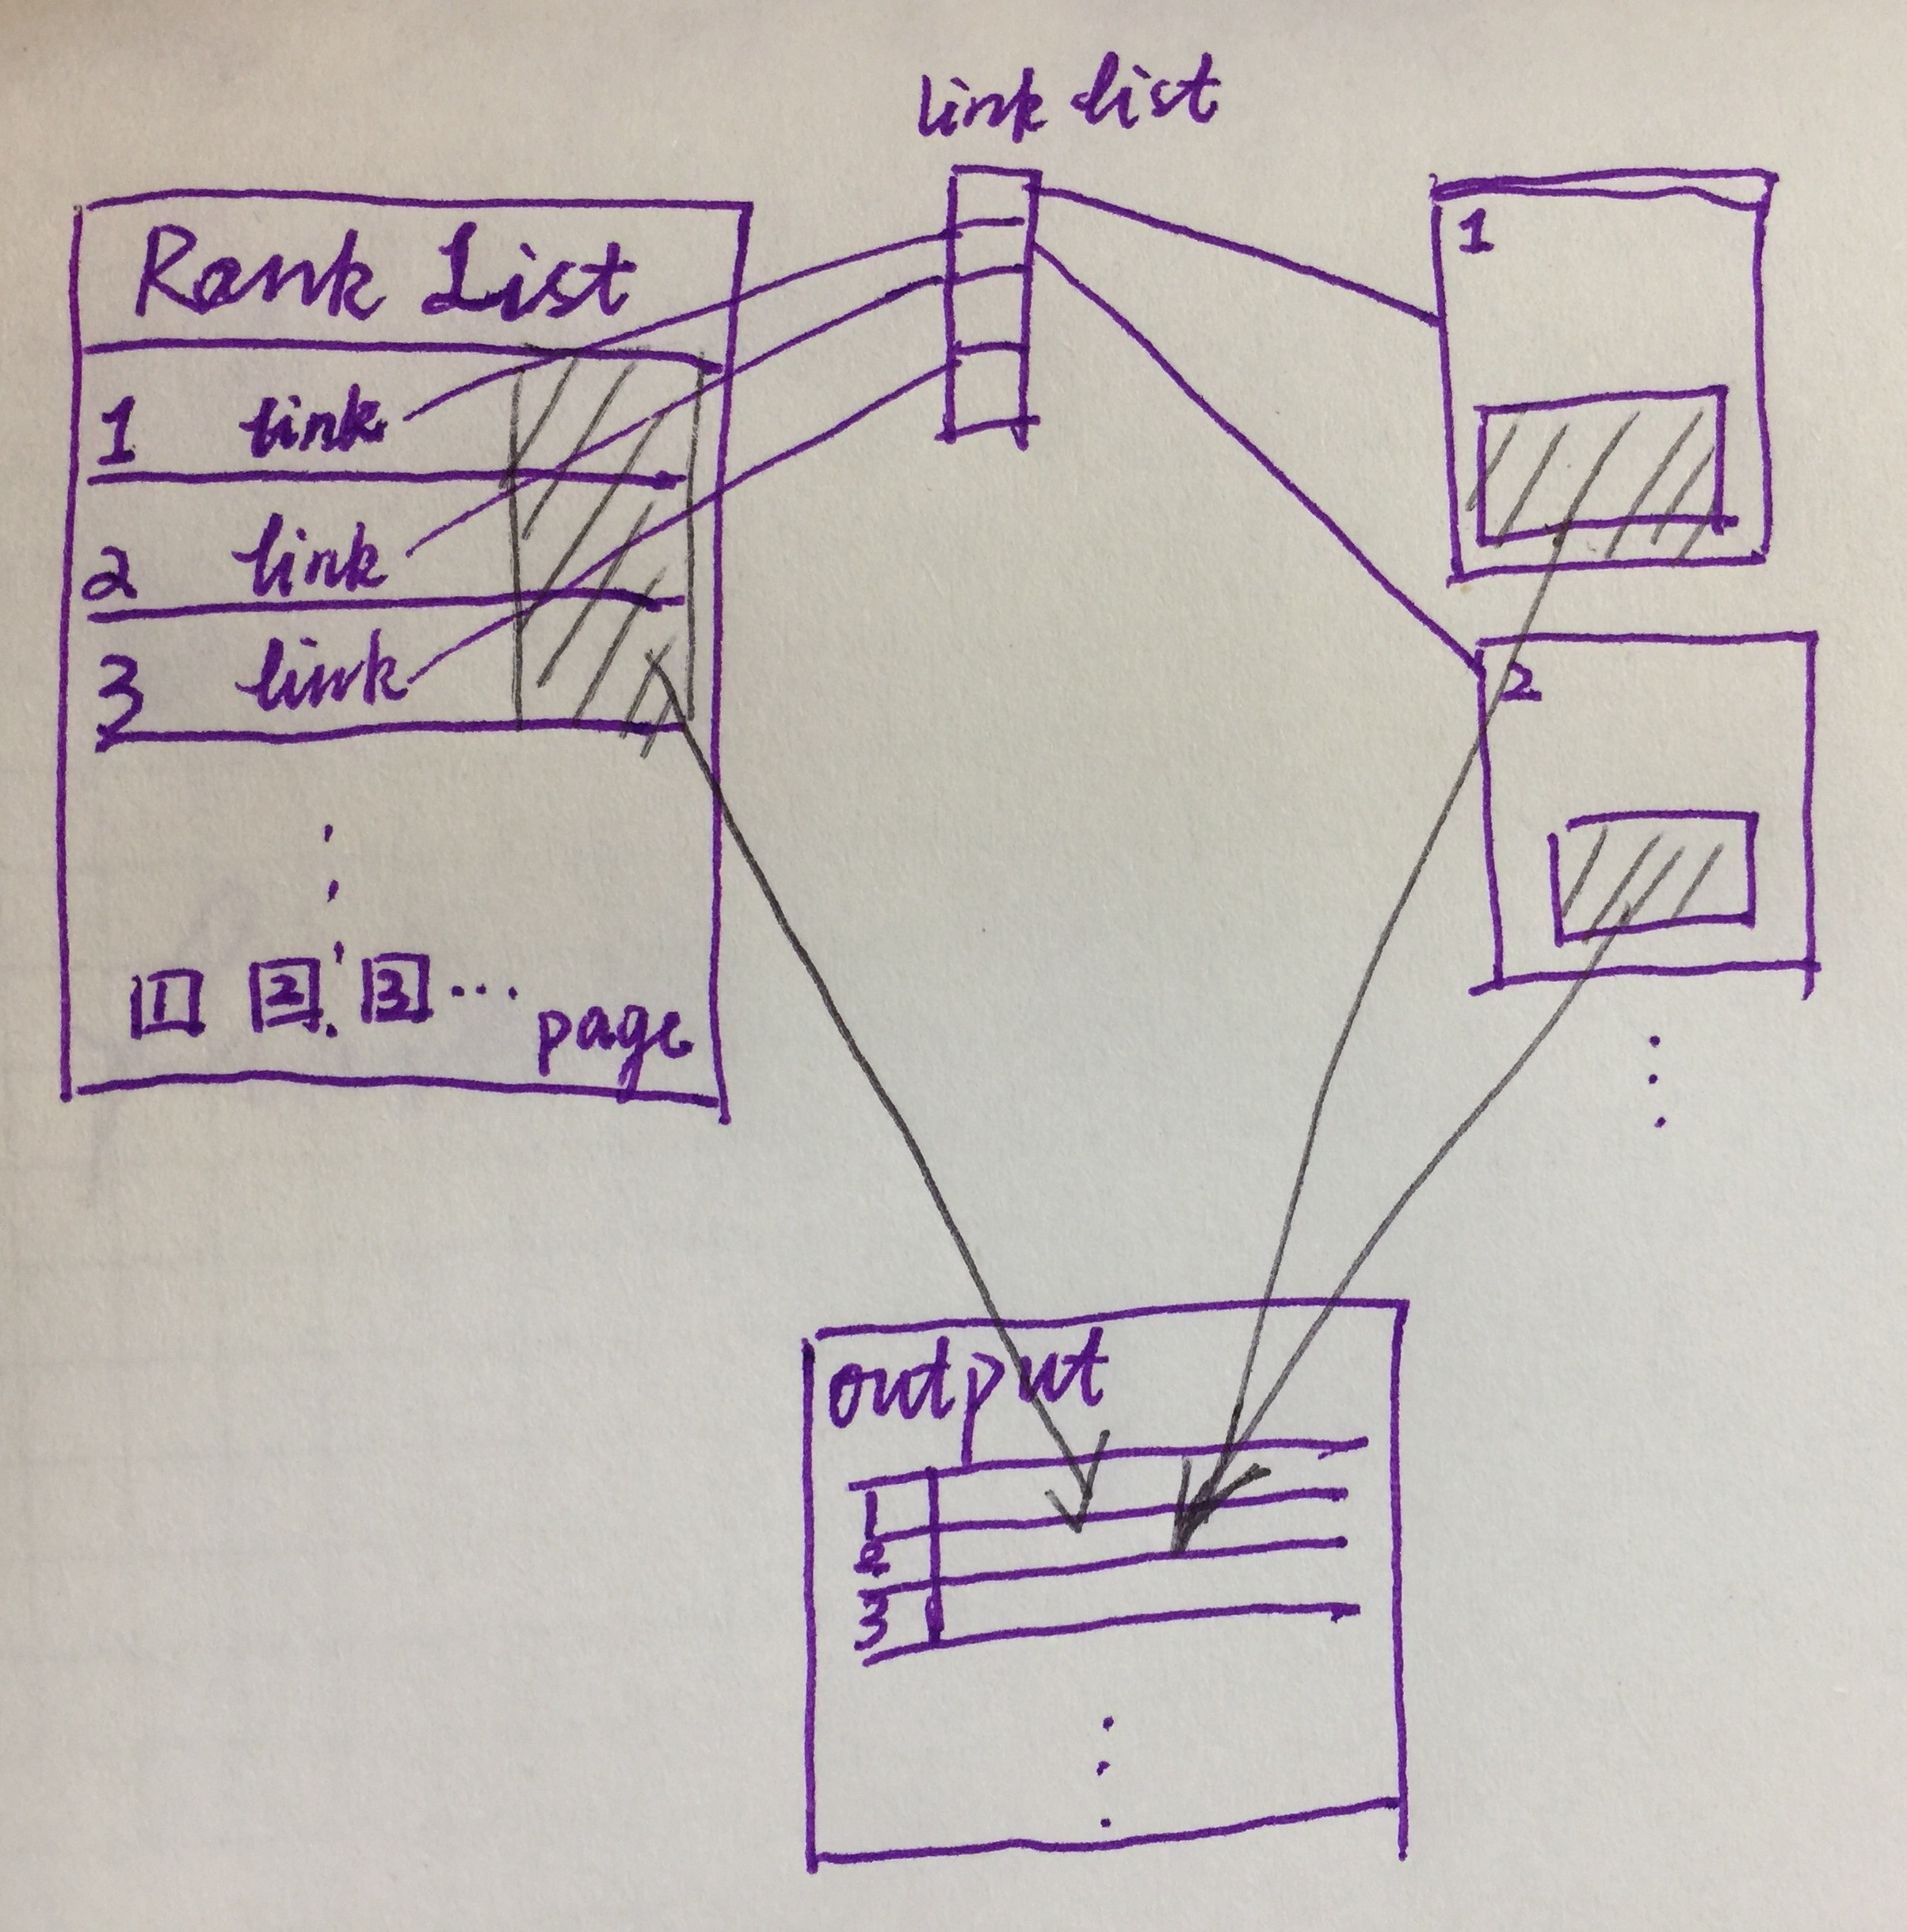

In [16]:
Image("steps.jpg")

## examine the Xpaths of needed elements

In [22]:
def get_urls():  # get the list of urls for further infomation
    link_list = []
    items = driver.find_elements_by_xpath('//a[@class="ranking-institution-title"]')
    for item in items:
        link_list.append(item.get_attribute('href'))
        time.sleep(1)
    #link_list
    return link_list

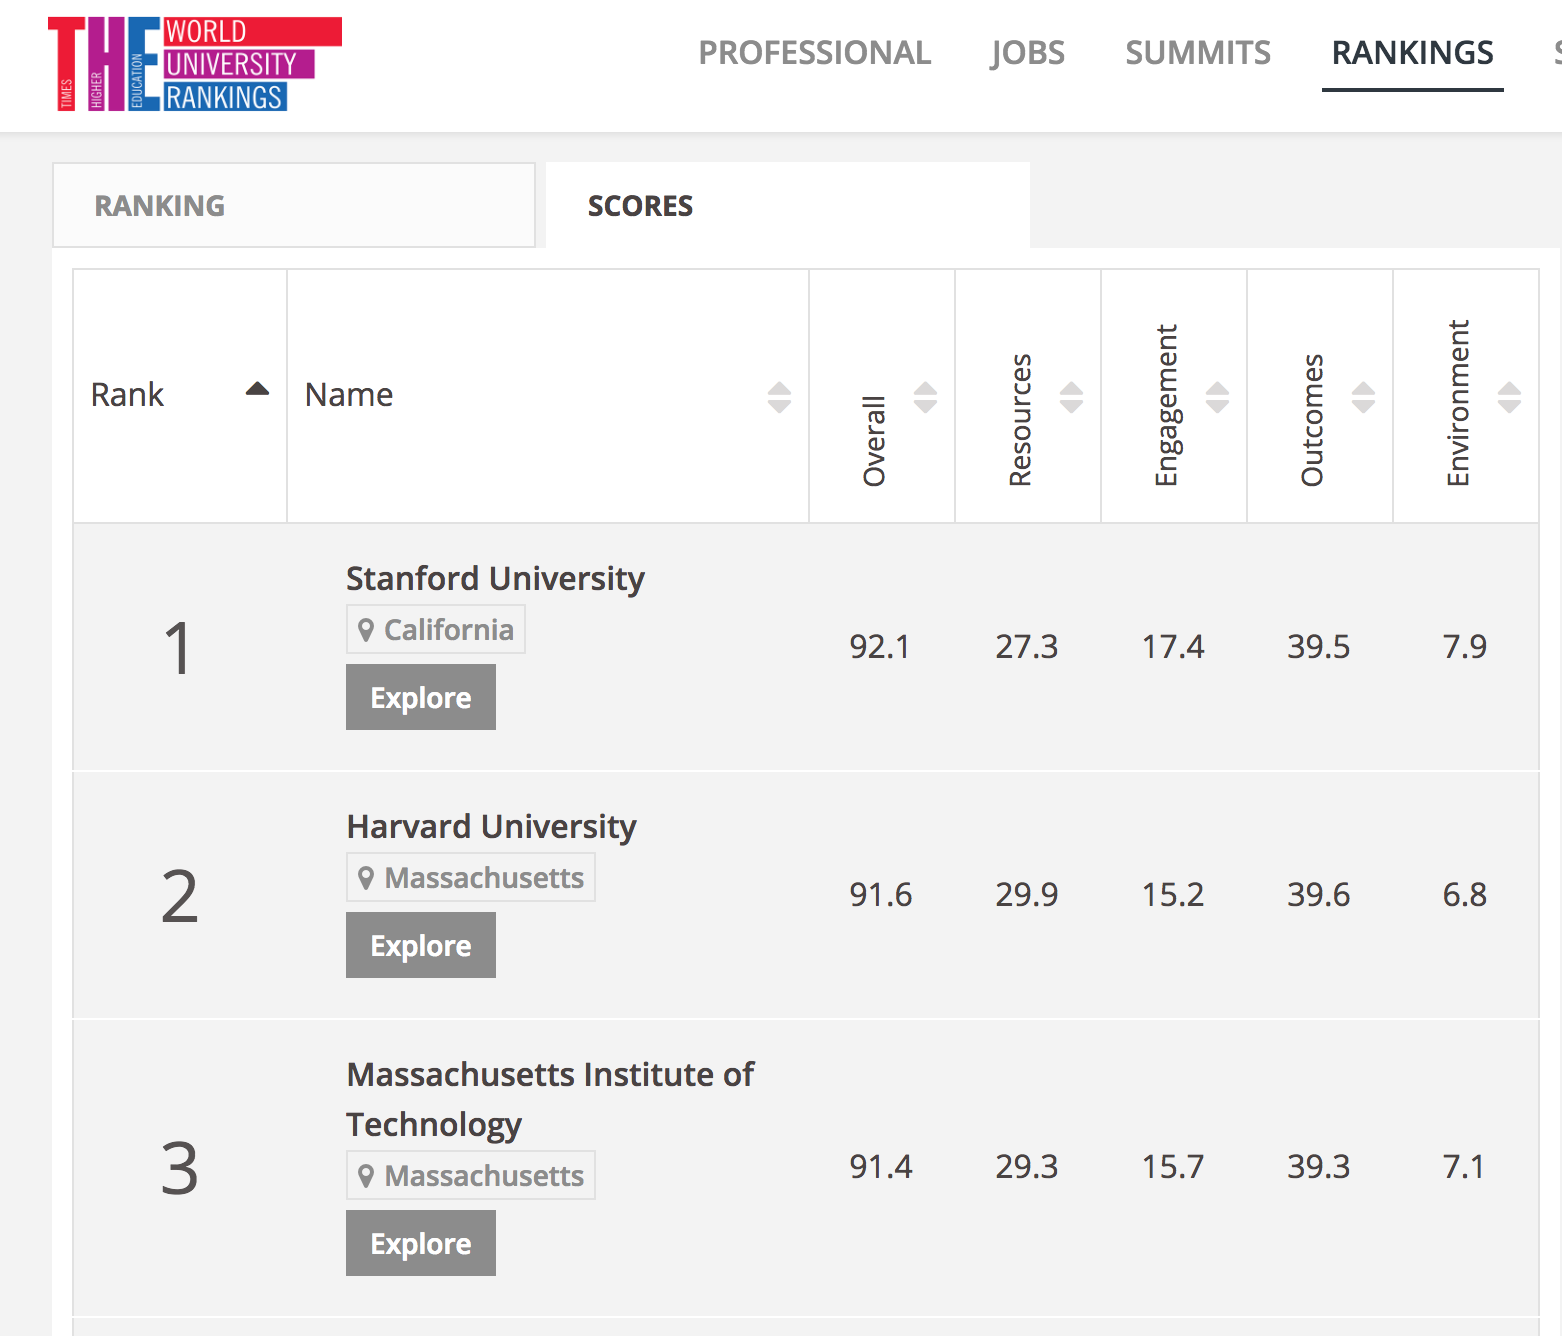

In [19]:
Image("ranking list.png")

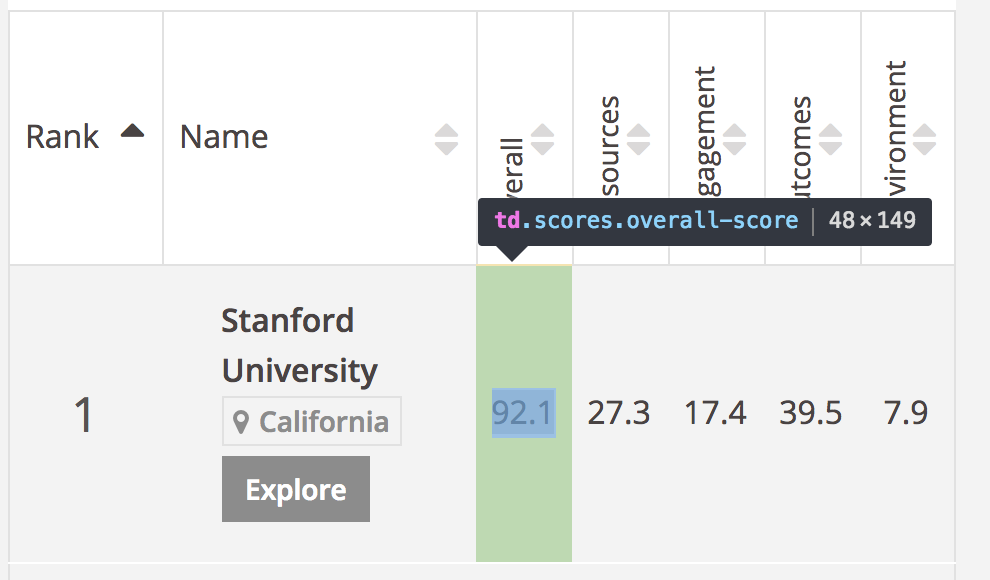

In [34]:
Image("Xpath.png")

In [20]:
                #class name
WSJlist_score=[['a','"ranking-institution-title"'],
         ['div','"location"'],
        ['td','" scores overall-score"'],
        ['td','" scores resources-score"'],
        ['td','" scores engagement-score"'],
        ['td','" scores outcomes-score"'],
        ['td','" scores environment-score"']
        ] # this list stores the type and the name of the XPaths

In [21]:
def WSJ_data(WSJlist): # this function scrapes the website according to the specified XPath List
    df = pd.DataFrame()
    for i in range(0,len(WSJlist)):
        items = driver.find_elements_by_xpath('//'+WSJlist[i][0]+'[@class='+WSJlist[i][1]+']')
        temp_list = []
        for item in items:
            temp_list.append(item.text)
        time.sleep(1)
        df[WSJlist[i][1].strip().replace(' ','').replace('"','')]=temp_list
    return df 

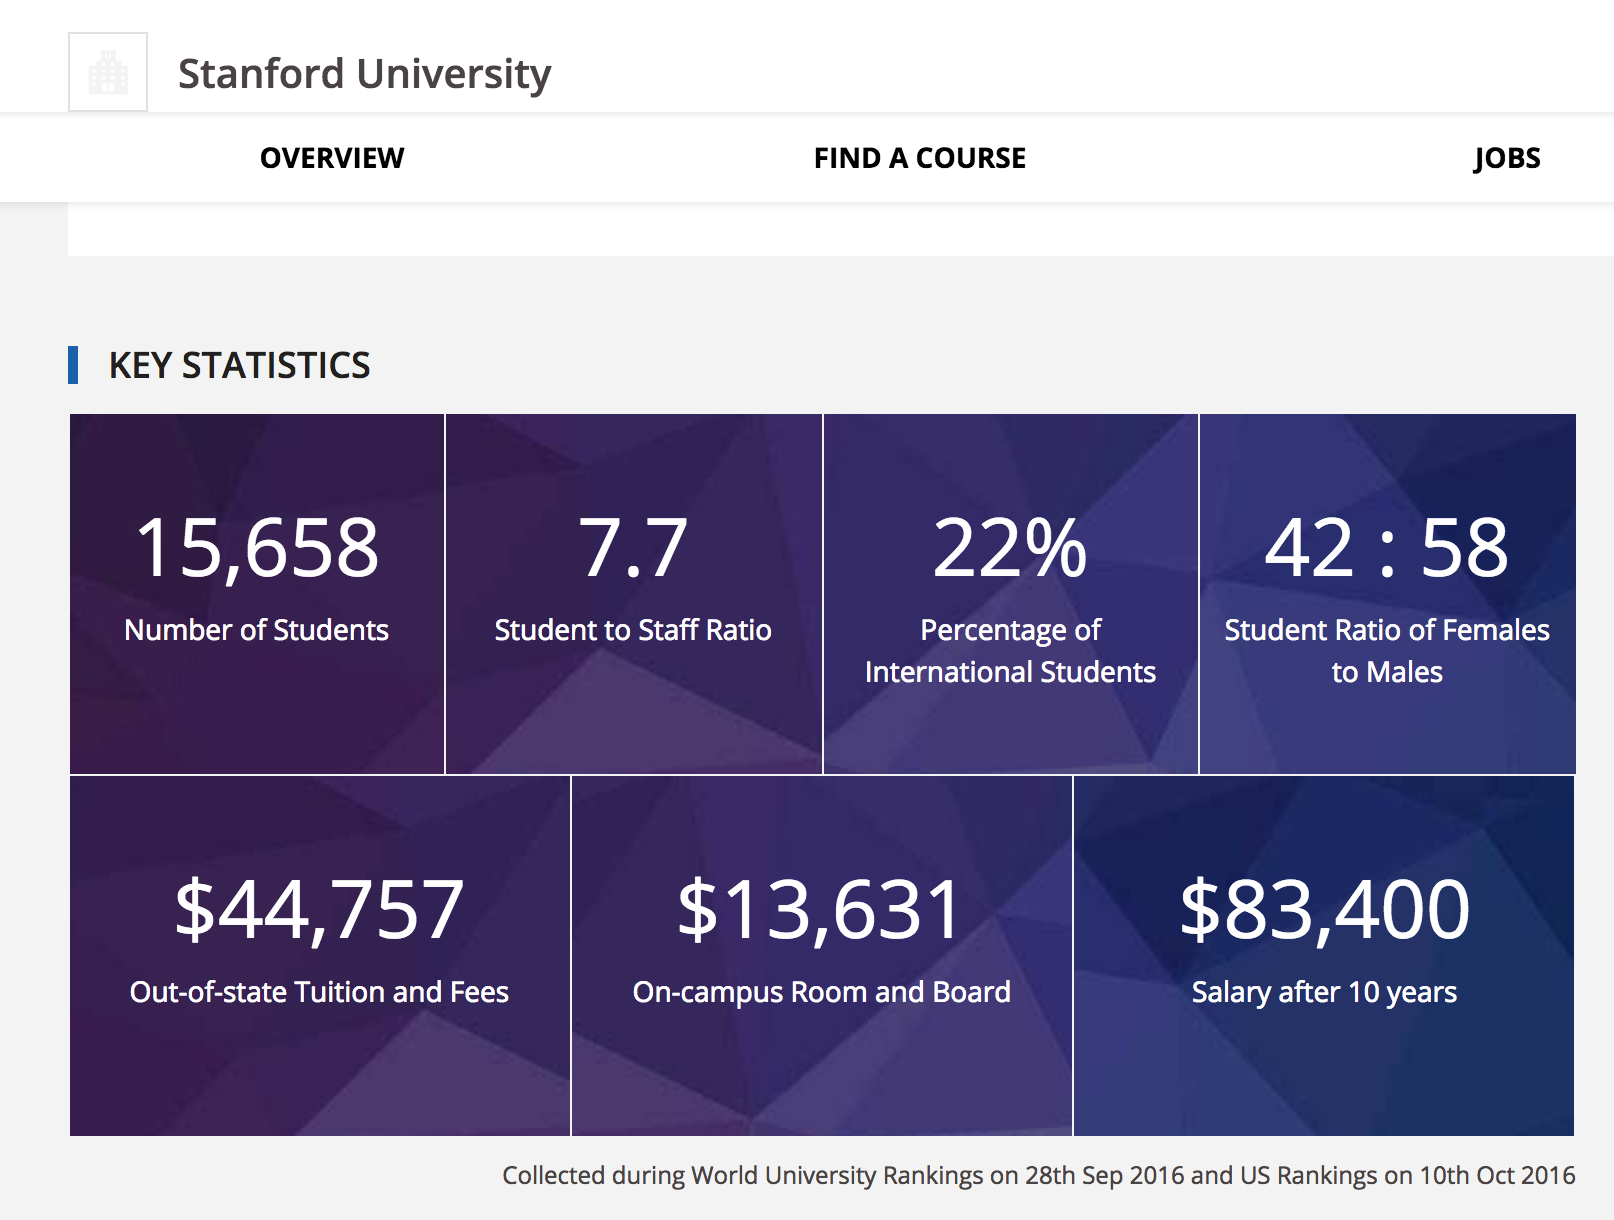

In [3]:
Image("university statistics.png")

In [23]:
def add_columns(dfName, link_list): # based on the first link in link_list, the functions creates columns in dataFrame dfName
    # add columns to the data frame
    soup=BeautifulSoup(requests.get(link_list[0]).text, "lxml")
    elements = soup.find_all(class_='keystats')
    for element in elements:
        column_name = (str(element).split('"')[1].split(' ')[1])
        dfName[column_name]=np.nan
    time.sleep(1)

In [24]:
def add_values(dfName, link_list): # this function scrapes each link in link_list and fills out dataFrame dfName
    for i in range(0, len(link_list)):   
        soup=BeautifulSoup(requests.get(link_list[i]).text, "lxml")
        elements = soup.find_all(class_='keystats')
        for element in elements:
            column_name = (str(element).split('"')[1].split(' ')[1])
            value = str(element.fetchPreviousSiblings()[0]).split('>')[1].split('<')[0]
            if column_name == 'number_students':
                cal_value = int(value.replace(',',''))
            elif column_name == 'student_staff_ratio':
                cal_value = value
            elif column_name == 'pc_intl_students':
                cal_value = float(value.replace('%',''))/100
            elif column_name == 'female_male_ratio':
                cal_value = round(float(value.split(':')[0])/float(value.split(':')[1]),3)
            else:
                cal_value = int(value.replace('$','').replace(',',''))
            dfName[column_name][i]= cal_value
        time.sleep(1)
    

In [36]:
chromedriver_path = "/Users/boyingliu/chromedriver"
#driver = webdriver.Chrome(chromedriver_path)

In [ ]:
# main function to scrape data
# the function loops through each tab in the website and pickles the dataset and the linklist
for page_index in range(0, len(page_number)): 
    driver = webdriver.Chrome(chromedriver_path)
    # every 100
    page_link = 'https://www.timeshighereducation.com/rankings/united-states/2017#!/page/'+str(page_number[page_index])+'/length/100/sort_by/rank/sort_order/asc/cols/scores'
    print(page_link)
    driver.get(page_link)
    time.sleep(1); # so not be blocked by the website
    WSJ_score=WSJ_data(WSJlist_score)
    pickle.dump(WSJ_score, open('WSJ_score_'+str(page_number[page_index]*100)+'.p', "wb" ) )
    
    link_list = get_urls()
    pickle.dump(link_list, open( "WSJ_link_list_"+str(page_number[page_index]*100)+".p", "wb" ) )


https://www.timeshighereducation.com/rankings/united-states/2017#!/page/0/length/100/sort_by/rank/sort_order/asc/cols/scores
https://www.timeshighereducation.com/rankings/united-states/2017#!/page/1/length/100/sort_by/rank/sort_order/asc/cols/scores
https://www.timeshighereducation.com/rankings/united-states/2017#!/page/2/length/100/sort_by/rank/sort_order/asc/cols/scores
https://www.timeshighereducation.com/rankings/united-states/2017#!/page/3/length/100/sort_by/rank/sort_order/asc/cols/scores
https://www.timeshighereducation.com/rankings/united-states/2017#!/page/4/length/100/sort_by/rank/sort_order/asc/cols/scores

In [ ]:
# merges all the pickled datasets and linklists 
WSJList = []
linkList = []
for page_index in range(0, len(page_number)):
    WSJ_score = pickle.load( open('WSJ_score_'+str(page_number[page_index]*100)+'.p', "rb" ) )
    WSJList.append(WSJ_score)
    link_list = pickle.load( open( "WSJ_link_list_"+str(page_number[page_index]*100)+".p", "rb" ) )
    linkList+=link_list

WSJ=[WSJitem for WSJitem  in WSJList]
WSJ = pd.concat(WSJ).reset_index()
# WSJ is the merged dataset and linkList is the merged link list

In [ ]:
add_columns(WSJ, linkList)
add_values(WSJ, linkList)

In [ ]:
# pickles the final dataset and linklist
pickle.dump(WSJ, open( "WSJ.p", "wb" ) )
pickle.dump(linkList, open( "linkList.p", "wb" ) )

In [28]:
linkList = pickle.load(open("linkList.p", "rb" ) )

In [29]:
linkList[:5]

['https://www.timeshighereducation.com/world-university-rankings/stanford-university#ranking-dataset/596947',
 'https://www.timeshighereducation.com/world-university-rankings/harvard-university#ranking-dataset/596947',
 'https://www.timeshighereducation.com/world-university-rankings/massachusetts-institute-technology#ranking-dataset/596947',
 'https://www.timeshighereducation.com/world-university-rankings/university-pennsylvania#ranking-dataset/596947',
 'https://www.timeshighereducation.com/world-university-rankings/columbia-university#ranking-dataset/596947']

In [26]:
WSJ = pickle.load(open("WSJ.p", "rb" ) )

In [27]:
WSJ.head(5)

,index,ranking-institution-title,location,scoresoverall-score,scoresresources-score,scoresengagement-score,scoresoutcomes-score,scoresenvironment-score,number_students,student_staff_ratio,pc_intl_students,female_male_ratio,fees_oos,room_board,salary_10_years
0,0,Stanford University,California,92.1,27.3,17.4,39.5,7.9,15658.0,7.7,0.22,0.724,44757.0,13631.0,83400.0
1,1,Harvard University,Massachusetts,91.6,29.9,15.2,39.6,6.8,19890.0,8.8,0.25,NaN,43938.0,14669.0,91300.0
2,2,Massachusetts Institute of Technology,Massachusetts,91.4,29.3,15.7,39.3,7.1,11192.0,8.8,0.34,0.587,45016.0,13224.0,90400.0
3,3,University of Pennsylvania,Pennsylvania,91.3,27.2,17.6,39.6,6.9,20367.0,6.5,0.20,1.041,47668.0,13464.0,78900.0
4,4,Columbia University,New York,91.1,27.1,16.8,39.6,7.8,25659.0,6.0,0.30,NaN,51008.0,12432.0,74000.0


In [31]:
WSJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
index                        500 non-null int64
ranking-institution-title    500 non-null object
location                     500 non-null object
scoresoverall-score          500 non-null object
scoresresources-score        500 non-null object
scoresengagement-score       500 non-null object
scoresoutcomes-score         500 non-null object
scoresenvironment-score      500 non-null object
number_students              135 non-null float64
student_staff_ratio          135 non-null float64
pc_intl_students             134 non-null float64
female_male_ratio            128 non-null float64
fees_oos                     500 non-null float64
room_board                   496 non-null float64
salary_10_years              499 non-null float64
dtypes: float64(7), int64(1), object(7)
memory usage: 58.7+ KB


In [32]:
WSJ = WSJ.drop('index', 1)
WSJ.iloc[:,2:7] = WSJ.iloc[:,2:7].astype(float)

In [33]:
WSJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
ranking-institution-title    500 non-null object
location                     500 non-null object
scoresoverall-score          500 non-null float64
scoresresources-score        500 non-null float64
scoresengagement-score       500 non-null float64
scoresoutcomes-score         500 non-null float64
scoresenvironment-score      500 non-null float64
number_students              135 non-null float64
student_staff_ratio          135 non-null float64
pc_intl_students             134 non-null float64
female_male_ratio            128 non-null float64
fees_oos                     500 non-null float64
room_board                   496 non-null float64
salary_10_years              499 non-null float64
dtypes: float64(12), object(2)
memory usage: 54.8+ KB


## there are different ways to achieve the same goal


### example 1

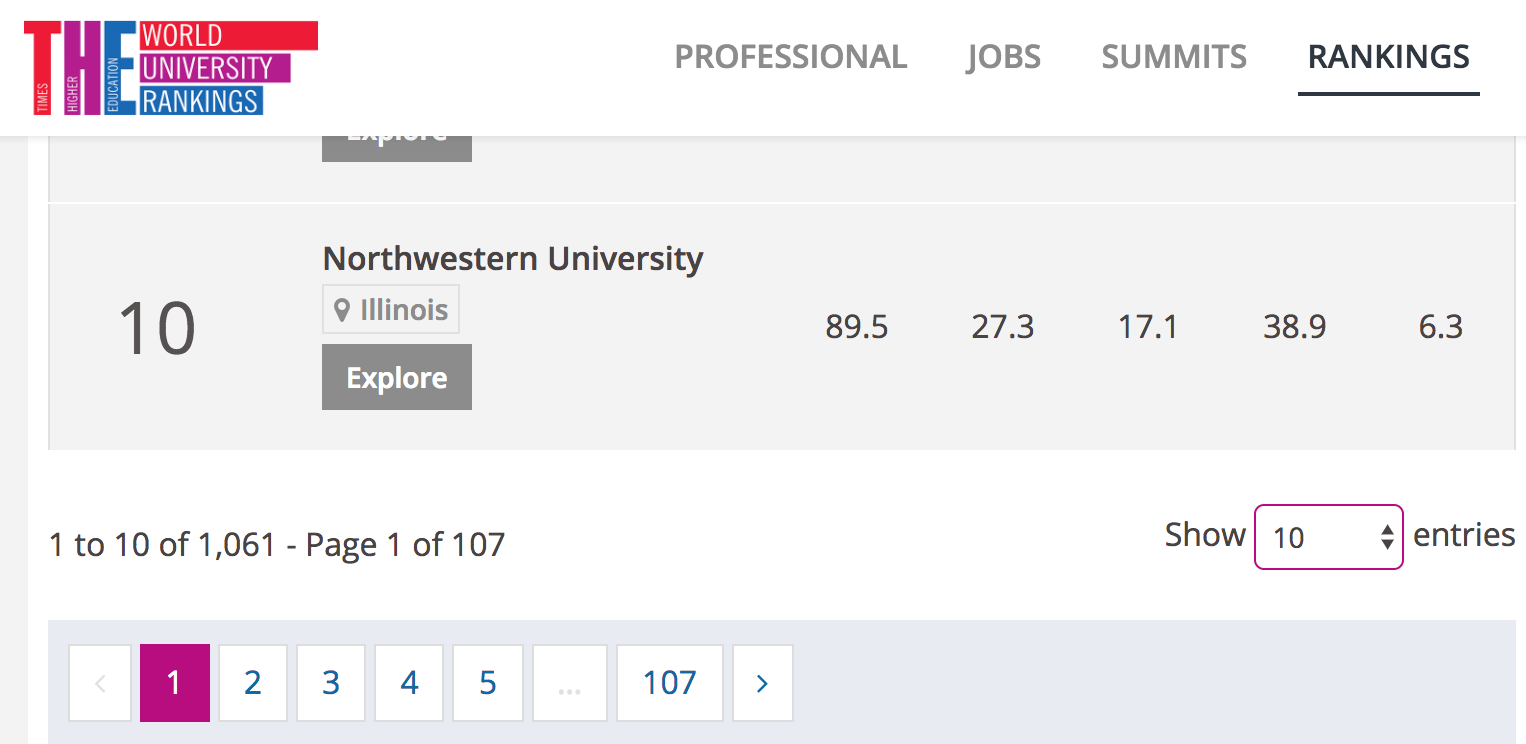

In [35]:
Image("ranking page.png")

In [59]:
driver = webdriver.Chrome(chromedriver_path)
page_link = 'https://www.timeshighereducation.com/rankings/united-states/2017#!/page/0/length/10/sort_by/rank/sort_order/asc/cols/scores'
print(page_link)
driver.get(page_link)

https://www.timeshighereducation.com/rankings/united-states/2017#!/page/0/length/10/sort_by/rank/sort_order/asc/cols/scores


In [60]:
element = driver.find_element_by_css_selector('#datatable-1_paginate > ul > li:nth-child(4) > a')

In [61]:
element.send_keys(Keys.RETURN)

### example 2

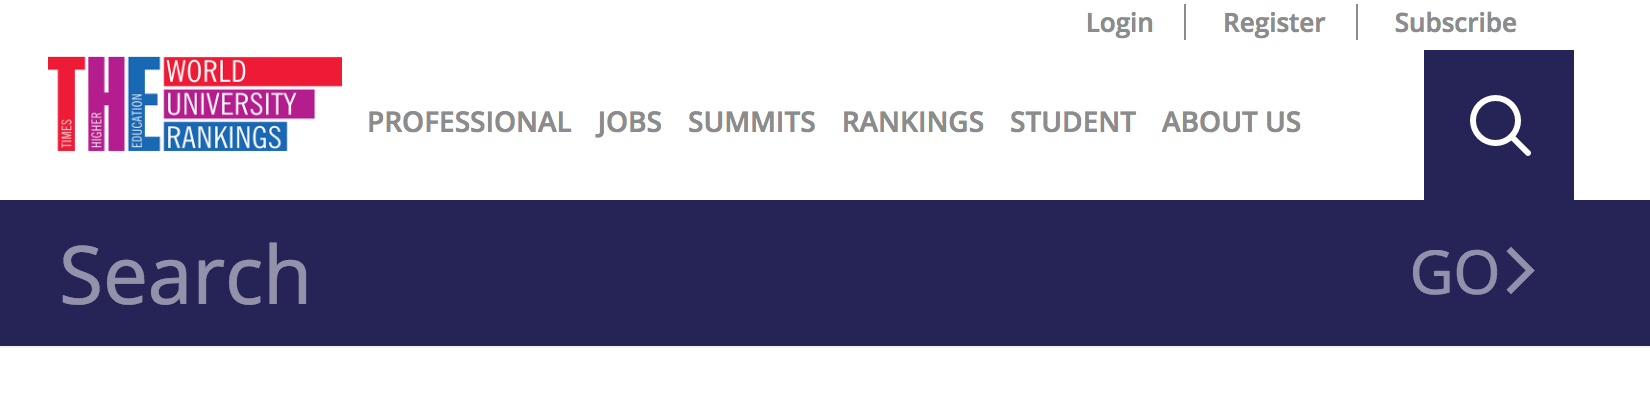

In [69]:
Image("search box.png")

In [63]:
element = driver.find_element_by_xpath('//*[@id="search-toggle"]')
element.click()

In [64]:
element = driver.find_element_by_xpath('//*[@id="edit-keys"]')

In [65]:
element.send_keys("Stanford University")

In [68]:
element.send_keys(Keys.RETURN)